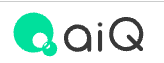

[disclaimer](../../disclaimer.txt/)

# aiQ Pos Cmsmr Goods/Elec/Retailer Evenly

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import plotly.io

for_html = False
if for_html:
    plotly.offline.init_notebook_mode()
else:
    plotly.io.renderers.default = 'iframe'

sys.path.append('../..')


In [3]:
verbose = False

## データロード

### データハンドラーのインポート

In [4]:
from aiq_strategy_robot.data.data_accessor import DAL

In [7]:
sdh = DAL()
dat_id_retail = load_retail(sdh)
data_id_goods = load_goods(sdh)
data_id_elec = load_elec(sdh)
data_id_mkt = load_mkt(sdh)

sdh.set_alias(
    {dat_id_retail: 'retail', data_id_goods: 'goods', 
     data_id_elec: 'elec', data_id_mkt: 'mkt'})

,category,data_source,source,table,alias,tickers,index,start_datetime,end_datetime
data_id,,,,,,,,,
1,RawData,aiQ,pos_retailer,Unknown,Unknown,"[1925, 2212, 2267, 2651, 2653, 2659, 2660, 266...","[ticker, datetime]",2010-04-30 00:00:00,2024-02-29 00:00:00
2,RawData,aiQ,pos_goods,Unknown,Unknown2,"[1301, 1332, 1333, 1334, 1352, 1378, 1379, 138...","[ticker, datetime]",2008-03-16 00:00:00,2024-03-03 00:00:00
3,RawData,aiQ,pos_elec,Unknown,Unknown3,"[1956, 2180, 2321, 2323, 2326, 2354, 2388, 246...","[ticker, datetime]",2009-01-01 00:00:00,2024-02-11 00:00:00
4,RawData,aiQ,market,Unknown,Unknown4,"[1301, 1306, 1321, 1332, 1333, 1334, 1352, 137...","[ticker, datetime]",2009-03-02 00:00:00,2024-03-11 00:00:00


### `AltDataEvaluator`作成
セットアップしたデータハンドラーを渡し`AltDataEvaluator`を作成

In [8]:
from aiq_strategy_robot.evaluator import AltDataEvaluator, inv_return_stats, cumplot_return

# Initialize AltDataEvaluator
ade = AltDataEvaluator(sdh)

In [9]:
sdh.transform.verbose = True

## バックテスト

In [10]:
# リターン作成
bcktest_return_id = sdh.transform.log_diff(1, data_id=data_id_mkt, fields='close').variable_ids[0]

### POS CSMR Goods weekly

In [11]:
n_shift = 6
n_rolling = 12
n_diff = 52

In [12]:
signal_goods_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_goods)
    .resample('W', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=7)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)

In [13]:
nq = 3
exe_cost = 0.0005

dfqret_goods, stats, dfsigqt = ade.q_backtest(
    signal_goods_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

Variables being created..: process: 1, method=log_diff(periods=1): 100%|█| 1/1 [00:05<00:00,  5.74
Variables being created..: process: 11, method=shift(periods=6): 100%|█| 10/10 [00:08<00:00,  1.12


,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.404237,0.027379,0.134257,0.203931,0.545455,9.808951,-0.521708,0.052480
#2,0.922646,0.062491,0.136107,0.459134,0.536863,12.867590,-0.396555,0.157585
#3,1.237880,0.083842,0.136761,0.613055,0.552384,10.053583,-0.421545,0.198893
#3-#1,0.833643,0.056463,0.048385,1.166963,0.532428,19.862534,-0.071782,0.786589
#3-#1(cost),0.687014,0.046532,0.048394,0.961521,0.529102,19.862534,-0.075392,0.617198


### POS Retailer Monthly

In [14]:
n_shift = 7
n_rolling = 2
n_diff = 12

In [15]:
signal_retailer_id = (
    sdh.transform
    .multiply('pos_sales', 'share', data_id=dat_id_retail)
    .resample('M', 'last')
    .sma(n_rolling)
    .log_diff(n_diff)
    .resample('D', 'last')
    .fillna('ffill', limit=31)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)


In [16]:
nq = 3
exe_cost = 0.0005

dfqret_retailer, stats, dfsigqt = ade.q_backtest(
    signal_retailer_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

Variables being created..: process: 21, method=shift(periods=7): 100%|█| 10/10 [00:05<00:00,  1.99


,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,0.560540,0.043914,0.136987,0.320574,0.530298,11.530233,-0.591806,0.074204
#2,1.158385,0.090751,0.144999,0.625877,0.546970,12.483664,-0.458667,0.197859
#3,1.665846,0.130507,0.145841,0.894863,0.547291,9.696185,-0.446487,0.292298
#3-#1,1.105306,0.086593,0.071953,1.203473,0.529336,21.226418,-0.173242,0.499839
#3-#1(cost),0.969835,0.075980,0.071955,1.055939,0.526451,21.226418,-0.186181,0.408096


### POS Elec Daily

In [17]:
n_shift = 4
n_rolling = 20
n_diff = 252
min_period = int(max(np.floor(n_rolling * 5 / 7), 1))

In [18]:
signal_elec_id = (
    sdh.transform
    .multiply('pos_sales', 'unit_price', data_id=data_id_elec)
    .resample('D', 'last')
    .sma(n_rolling, min_period)
    .reindex(label=bcktest_return_id)
    .log_diff(n_diff)
    .reindex(label=bcktest_return_id)
    .shift(n_shift)
    .variable_ids[0]
)


In [19]:
nq = 3
exe_cost = 0.0005

dfqret_elec, stats, dfsigqt = ade.q_backtest(
    signal_elec_id,
    bcktest_return_id,
    nq=nq,
    exe_cost=exe_cost,
    plot=True,
    stats=True
)

Variables being created..: process: 30, method=shift(periods=4): 100%|█| 9/9 [00:16<00:00,  1.78s/


,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,ann.TurnOver,Max_DD,Calmar Ratio
#1,-0.291576,-0.020937,0.209285,-0.100043,0.521305,18.113213,-0.787301,-0.026594
#2,0.657707,0.047229,0.204511,0.230934,0.528063,32.881597,-0.561574,0.084100
#3,1.140066,0.081866,0.200629,0.408047,0.538349,18.619088,-0.479548,0.170715
#3-#1,1.431642,0.102803,0.113726,0.903956,0.522774,36.732300,-0.156895,0.655235
#3-#1(cost),1.175875,0.084437,0.113745,0.742339,0.517778,36.732300,-0.165325,0.510736


## ポートフォリオ

In [20]:
elec_long_short = dfqret_elec['#3-#1'].rename('elec')
csmr_long_short = dfqret_goods['#3-#1'].rename('csmr')
retailer_long_short = dfqret_retailer['#3-#1'].rename('retailer')

elec_long_short = elec_long_short.resample('M').sum()
csmr_long_short = csmr_long_short.resample('M').sum()
retailer_long_short = retailer_long_short.resample('M').sum()

min_date = retailer_long_short.index.min()
max_date = elec_long_short.index.max()

portfolio = pd.concat([elec_long_short, csmr_long_short, retailer_long_short],axis=1)
portfolio = portfolio[portfolio.index>min_date]
portfolio = portfolio[portfolio.index<max_date]

portfolio['portfolio'] = portfolio.mean(axis=1)

In [21]:
cumplot_return(portfolio, em_pattern='portfolio')
inv_return_stats(portfolio)

,cum.Ret,ann.Ret,ann.Std,R/R,Win_R,Max_DD,Calmar Ratio
elec,1.467871,0.117314,0.106480,1.101748,0.655629,-0.143463,0.817730
csmr,0.751345,0.060048,0.045448,1.321241,0.655629,-0.057217,1.049477
retailer,1.124635,0.089882,0.082794,1.085612,0.629139,-0.151485,0.593342
portfolio,1.114617,0.089082,0.047335,1.881956,0.748344,-0.052906,1.683778
